### Import libraries

In [15]:
import pennylane as qml
from pennylane import numpy as np

### Create a device with 2 qubits

In [16]:
#@title Create a device with 2 qubits
dev = qml.device("default.qubit", wires=2)

### Create a QNode with 2 entangled qubits (Bell state). Return the probabilities for each state.

In [17]:
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    return qml.probs()

### Draw circuit

(<Figure size 500x300 with 1 Axes>, <Axes: >)

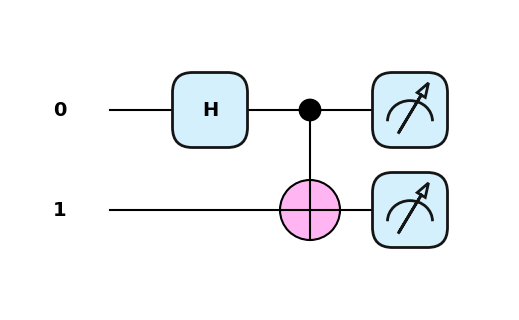

In [18]:
qml.draw_mpl(circuit, style='pennylane')()

### Run circuit

In [19]:
circuit()

tensor([0.5, 0. , 0. , 0.5], requires_grad=True)

## Introduction to QML
Train a circuit to model a sine function

In [20]:
# Import visualization graph
import matplotlib.pyplot as plt

#### Step 0: Prepare data

In [21]:
# Training data
X = np.linspace(0, 2*np.pi, 1000)
y = np.sin(X)

# Testing data
X_test = np.linspace(0.2, 2*np.pi+0.2, 10)
y_test = np.sin(X_test)

#### Step 1: Create the device

In [22]:
dev = qml.device("default.qubit", wires=1)

#### Step 2: Create the quantum circuit
1. Encode the input data as an RX rotation
2. Create an RY and an RX rotation based on the angles in "params"
3. We return the expected value of a measurement along the Z axis


In [23]:
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encoding
    qml.RX(datapoint, wires=0)
    # Ansatz
    qml.RY(params[0], wires=0)
    qml.RX(params[1], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

(<Figure size 600x200 with 1 Axes>, <Axes: >)

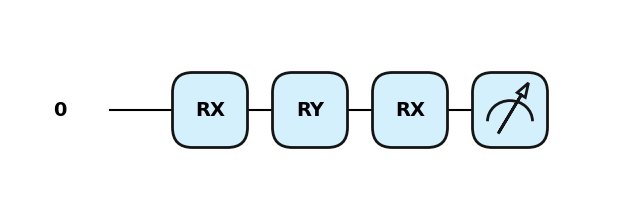

In [24]:
qml.draw_mpl(quantum_circuit, style='pennylane')(0.1, [0.2, 0.3])

#### Step 3: Classical Pre/Postprocessing

In [25]:
# Loss function
def loss_func(predictions, targets):
    total_loss = 0
    for i in range(len(targets)):
        label = targets[i]
        prediction = predictions[i]
        loss = (prediction - label) ** 2
        total_loss += loss
    return total_loss

#### Step 4: Define cost function, including any classical pre/postprocessing

In [26]:
def cost_fn(params, X, y):
    # For a single value of the parameters we run the quantum circuit 10 times, once per datapoint (x)
    predictions = [quantum_circuit(x, params) for x in X]
    cost = loss_func(predictions, y)
    return cost

#### Step 5: Optimize
In this scenario, we use Gradient Descent

In [27]:
# Choose an optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Make an initial guess for the parameters and set them as trainable (initialize parameters weights)
init_params = np.array([0.1, 0.1], requires_grad=True)

# Set data as non-trainable
X.requires_grad = False

# Choose a number of steps
max_iter = 50

def optimization_routine(max_iter, opt, cost_fn, params, X, y):
    # Loop through max_iter
    for i in range(max_iter):
        [params, _, _], prev_cost = opt.step_and_cost(cost_fn, params, X, y)
        if i % 5 == 0:
            # Print the result after 5 steps
            print(f'Step = {i} Cost = {cost_fn(params, X, y)}')
    
    # Print the value of the optimized parameters
    print('Final parameters: ', params)
    return params

final_params = optimization_routine(max_iter, opt, cost_fn, init_params, X, y)

Step = 0 Cost = 417.0410340164385
Step = 5 Cost = 1055.0313502472152
Step = 10 Cost = 189.83600761742
Step = 15 Cost = 1157.3966225037002
Step = 20 Cost = 1740.774127263571
Step = 25 Cost = 37.820617008970046
Step = 30 Cost = 1757.9510309621182
Step = 35 Cost = 445.646602126629
Step = 40 Cost = 741.8437814386955
Step = 45 Cost = 1177.9748779905146
Final parameters:  [  114.59975922 -1428.5569171 ]


#### Step 6: Test and graph results

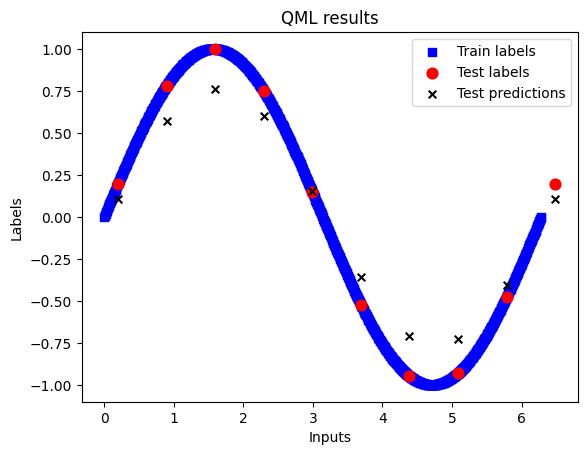

In [28]:
# Output of quantum circuit for test data
test_predictions = [quantum_circuit(x_test, final_params) for x_test in X_test]

# Create a scatter plot showing the training and test data as well as the test predictions
def plot_results(X, y, X_test, y_test, test_predictions):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(X, y, s=30, c='b', marker='s', label='Train labels')
    ax1.scatter(X_test, y_test, s=60, c='r', marker='o', label='Test labels')
    ax1.scatter(X_test, test_predictions, s=30, c='k', marker='x', label='Test predictions')
    plt.xlabel("Inputs")
    plt.ylabel("Labels")
    plt.title("QML results")

    plt.legend(loc='upper right');
    plt.show()

plot_results(X, y, X_test, y_test, test_predictions)
